In [1]:
# jax
import jax
# jax.config.update("jax_default_device",jax.devices()[1])
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
from jax.random import PRNGKey as pkey
from jax.scipy.linalg import solve
# Other libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.style.use("ggplot")
from importlib import reload
from functools import partial

# Our libraries
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import (OperatorModel, OperatorPDEModel,CholInducedRKHS,
                            CholOperatorModel)
import plotting
reload(plotting)
from plotting import (plot_obs,plot_compare_error,
                      plot_input_data,plot_compare_error,
                      plot_obs_parabolic, plot_init_final_parabolic)

from evaluation_metrics import get_nrmse,table_u_errors
from data_utils import (
    get_xy_grid_pairs, # changed - could live in parabolic_data_utils ?
    build_xy_grid,
    sample_xy_grid_latin,
    build_input_observations,
    build_u_obs_single,
    build_u_obs_all,
    sample_multiple_xy_grids_latin
)

from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data,
    GP_Sampler_1D_Pinned
)

from Kernels import (
    get_gaussianRBF,
    get_centered_scaled_poly_kernel,
    fit_kernel_params,log1pexp,
    inv_log1pexp,get_anisotropic_gaussianRBF
)

In [5]:
def run_exp_opt_err(gamma,n_obs,run):

    # Sample m training functions as initial conditions from a GP
    m = 1
    kernel_GP = get_gaussianRBF(0.2)
    xy_pts = jnp.linspace(0,1,50) # Pts to build interpolants
    u0_true_functions = tuple(GP_Sampler_1D_Pinned(num_samples = m,
                                            X = xy_pts, 
                                            smooth = gamma,
                                            kernel = kernel_GP,
                                            reg = 1e-8,
                                            seed = 2024
                                        )
                            )

    vec_u0_true_functions = tuple([np.vectorize(u) for u in u0_true_functions])
    vmapped_u0_true_functions = tuple([jax.vmap(u) for u in u0_true_functions])
    # Solve m Burgers' equations with IC's: u0_true_functions 
    # kappa = 0.001
    # alpha = 5.
    kappa = 0.01
    alpha = 1.

    u_true_functions = []
    ut_true_functions = []
    interpolants = []
    t_vals_s = []
    sols_s = []

    for u0_true_function in vec_u0_true_functions:
        res = list(build_burgers_data(func_u0=u0_true_function,
                        kappa = kappa,
                        alpha = alpha,
                        k_timestep=0.0001,
                        n_finite_diff=1999))
        u_true_functions.append(res[0])
        ut_true_functions.append(res[1])
        interpolants.append(res[2])
        t_vals_s.append(res[3])
        sols_s.append(res[4])

    # Ghost Chebyshev grids
    num_grid_x = 31
    num_grid_t = 26
    # num_grid_x = 7
    # num_grid_t = 6

    tx_ints , tx_bdys = [], []
    for _ in range(m):
        res = build_tx_grid_chebyshev([0,1],[0,1],
                                num_grid_t,
                                num_grid_x,
                                alpha = 0.5)
        tx_ints.append(res[0])
        tx_bdys.append(res[1])

    tx_ints = tuple(tx_ints)
    tx_bdys = tuple(tx_bdys)
    # Tuple of ghost grids
    tx_all = tuple(jnp.vstack([tx_int,tx_bdy]) for tx_int,tx_bdy in zip(tx_ints,tx_bdys))


    # List of number of observation points per u
    num_obs = [n_obs]*m

    # Get (X^m, u^m(X^m))
    tx_obs = []
    u_obs = []
    for i, (tx_int,tx_bdy) in enumerate(zip(tx_ints,tx_bdys)):
        _,tx_ob = setup_problem_data(
            tx_int,
            tx_bdy,
            num_obs[i],
            jax.random.PRNGKey(i),
            times_to_observe = (0,)
                )
        tx_obs.append(tx_ob)

    u_obs = tuple(u(tx_ob) for tx_ob,u in zip(tx_obs,u_true_functions))

    # Define grid to plot
    num_fine_grid = 300
    initial_time = 0
    final_time = 1
    t_fine,x_fine = jnp.meshgrid(jnp.linspace(initial_time,final_time,num_fine_grid),jnp.linspace(0,1,num_fine_grid))
    tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T

    # Plot initial and final conditions
    num_fine_grid = 500
    grid_points = jnp.linspace(0,1,num_fine_grid)

    # Features of u and P
    u_operators = (eval_k,) # This enforces 1_5 step method
    feature_operators = (eval_k,dx_k,dxx_k)


    # Fit parameters of kernel for u
    def param_ani_gaussian_RBF(x,y,params):
        lengthscales = log1pexp(params)
        return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)
    
    fitted_params_s = []
    ml_value_s = []
    k_u_s = []
    for i in range(m):
        res = fit_kernel_params(param_ani_gaussian_RBF,tx_obs[i],u_obs[i],jnp.zeros(2))
        ML_lengthscales = log1pexp(res[0])
        k_u_s.append(get_anisotropic_gaussianRBF(1.,jnp.diag(log1pexp(res[0]))))
        print(1/(jnp.sqrt(ML_lengthscales)))

    u_models = tuple([CholInducedRKHS(
        tx_all[i],
        u_operators,
        k_u_s[i]
        ) for i in range(m)])
    

    # Get necessary tuples
    observation_points = tuple(tx_obs)
    observation_values = tuple(u_obs)
    collocation_points = tx_ints

    all_u_params_init = tuple([
        model.get_fitted_params(obs_loc,obs_val)
        for obs_loc,obs_val,model in zip(observation_points,observation_values,u_models)])

    grid_features_u_init = jnp.vstack([(
        model.evaluate_operators(feature_operators,tx_int,model_params)).reshape(
                len(tx_int),
                len(feature_operators),
                order = 'F'
            ) for tx_int,model,model_params in zip(tx_ints,u_models,all_u_params_init)])

    k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_u_init,c=1.,scaling = 'diagonal')

    @vectorize_kfunc
    def k_P(x,y):
        return k_P_u_part(x[2:],y[2:])

    P_model = OperatorModel(k_P)

    EqnModel  = OperatorPDEModel(
        P_model,
        u_models,
        observation_points,
        observation_values,
        collocation_points,
        feature_operators,
        rhs_operator=dt_k,
        datafit_weight = 5.,
        )

    import LM_Solve
    import importlib
    importlib.reload(LM_Solve)
    from LM_Solve import LevenbergMarquadtMinimize,adaptive_refine_solution
    params_init = jnp.hstack(list(all_u_params_init)+[jnp.zeros(m*len(tx_ints[0]))])

    params,convergence_data = LevenbergMarquadtMinimize(
        params_init.copy(),
        EqnModel,
        beta = 1e-11,
        max_iter = 501,
        init_alpha=0.1,
        line_search_increase_ratio=1.4,
        print_every = 100
    )
    p_adjusted,refine_convergence_data = adaptive_refine_solution(params,EqnModel,1e-3,500)

    equation_residuals = EqnModel.equation_residual(params)
    equation_residuals_refined = EqnModel.equation_residual(p_adjusted)

    u_sols = EqnModel.get_u_params(p_adjusted)
    P_sol = EqnModel.get_P_params(p_adjusted)

    u_sols = EqnModel.get_u_params(params)
    P_sol = EqnModel.get_P_params(params)

    print(u_sols)
    print(P_sol)

    #### Operator learning error : 1.5 step method
    # Sample m u0 new functions from a GP
    M = 15
    kernel_GP = get_gaussianRBF(0.2)
    xy_pts = jnp.linspace(0,1,50) # Pts to build interpolants
    u0_new_true_functions = tuple(GP_Sampler_1D_Pinned(num_samples = M,
                                            X = xy_pts, 
                                            smooth= gamma,
                                            kernel = kernel_GP,
                                            reg = 1e-8,
                                            seed = run
                                        )
                            )

    vec_u0_new_true_functions = tuple([np.vectorize(u) for u in u0_new_true_functions])
    vmapped_u0_new_true_functions = tuple([jax.vmap(u) for u in u0_new_true_functions])
    # Solve m Burgers' equations with IC's: u0_true_functions 
    # kappa = 0.001
    # alpha = 5.
    kappa = 0.01
    alpha = 1.

    u_new_true_functions = []
    ut_new_true_functions = []
    interpolants_new = []
    t_vals_s_new = []
    sols_s_new = []

    for u0_new_true_function in vec_u0_new_true_functions:
        res = list(build_burgers_data(func_u0=u0_new_true_function,
                        kappa = kappa,
                        alpha = alpha,
                        k_timestep=0.0001,
                        n_finite_diff=1999))
        u_new_true_functions.append(res[0])
        ut_new_true_functions.append(res[1])
        interpolants_new.append(res[2])
        t_vals_s_new.append(res[3])
        sols_s_new.append(res[4])

    # Colocation points for learning u
    num_grid_x = 31
    num_grid_t = 26
    tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.5)

    tx_all,_ = setup_problem_data(
        tx_int,
        tx_bdy,
        60,
        jax.random.PRNGKey(55),
        times_to_observe = (0,)
    )
    
    tx_init_bdy = jnp.vstack([tx_int[tx_int[:,0]==0],tx_bdy])   

    tx_all_ = tx_all[0]

    # Object to capture learned solution : Fixing the first ?
    u_model = CholInducedRKHS(tx_all,
                            feature_operators,
                            k_u_s[0]
                            )

    def get_u_pde_adj(u0_new,method):
        model_grid_features = EqnModel.get_stacked_eqn_features(u_sols)
        # 1_5 method u_t
        @jit
        def get_pred_ut(input_features):
            return P_model.kernel_function(input_features,model_grid_features)@P_sol
        @jit
        def get_pred_ut_2step(input_features):
            init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)
            rhs_stacked = EqnModel.stacked_collocation_rhs
            P_params_naive = P_model.fit_params(init_P_features,rhs_stacked,nugget = 1e-8)
            return P_model.predict_new(input_features,init_P_features,P_params_naive)
        
        new_obs = u0_new(tx_init_bdy) 

        class PdeModel():
            datafit_weight = 50.
            @jit
            def get_grid_features(u_params):
                evaluation = u_model.evaluate_operators(feature_operators,tx_int,u_params)
                grid_features = evaluation.reshape(len(tx_int),len(feature_operators),order = 'F')
                return jnp.hstack([tx_int,grid_features])
            
            @jit
            def get_grid_target(u_params):
                return u_model.evaluate_operators((dt_k,),tx_int,u_params)
            
            @jit
            def eval_obs_points(u_params):
                return u_model.point_evaluate(tx_init_bdy,u_params)
            
            @jit
            def datafit_residual(u_params):
                obs_preds = PdeModel.eval_obs_points(u_params)
                return new_obs - obs_preds
            
            @jit
            def equation_residual(u_params):
                P_features = PdeModel.get_grid_features(u_params)
                P_model_preds = jnp.where(method == 1, get_pred_ut(P_features), get_pred_ut_2step(P_features))
                ugrid_target = PdeModel.get_grid_target(u_params)
                return (ugrid_target - P_model_preds)
            
            @jit
            def F(u_params):
                eqn_res = PdeModel.equation_residual(u_params)
                data_res = PdeModel.datafit_residual(u_params)
                return jnp.hstack([
                    PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                    eqn_res/jnp.sqrt(len(eqn_res))
                    ])
            
            jac = jit(jacrev(F))

            def loss(u_params):
                return jnp.linalg.norm(PdeModel.F(u_params))**2
            
            @jit
            def damping_matrix(u_params):
                return u_model.kmat+1e-5 * diagpart(u_model.kmat)
            

        # OPTIMIZE
        new_u_init = jnp.zeros(tx_all.shape[0]*len(feature_operators))

        u_params_pde,_ = LevenbergMarquadtMinimize(
            new_u_init.copy(),
            PdeModel,
            beta = 0.,
            max_iter = 101,
            init_alpha=0.05,
            line_search_increase_ratio=1.4,
            print_every = 10
        )
        u_pde_adj, _ = adaptive_refine_solution(u_params_pde,PdeModel,1e-1,150)

        return u_pde_adj
    
    
    # Define grid to test
    true = [u(tx_fine) for u in u_new_true_functions]

    pred1_5 = [u_model.point_evaluate(tx_fine,get_u_pde_adj(u0,method=1)) for u0 in u_new_true_functions]

    pred2 = [u_model.point_evaluate(tx_fine,get_u_pde_adj(u0,method=2)) for u0 in u_new_true_functions]

    i_opt_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)]))
    i_opt_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))



    return i_opt_1_5, i_opt_2

## Regularity

In [3]:
err = {
    '1_5_mthd': [],
    '2_mthd':   []
}

In [ ]:
NUM_RUNS = 3
REGULARITY = [1,2,3,4,5,6]
for gamma in REGULARITY:
    i_opt_1_5 = []
    i_opt_2 = []
    for run in range(NUM_RUNS):
        # Run
        res = run_exp_opt_err(gamma,60,run)
        # Append
        i_opt_1_5.append(res[0])
        i_opt_2.append(res[1])
    # Append each list    
    err['1_5_mthd'].append(i_opt_1_5)
    err['2_mthd'].append(i_opt_2)   
# Save after
jnp.save('errors_opt/err_vs_smooth', err)

In [3]:
err = jnp.load('errors_opt/err_vs_smooth.npy', allow_pickle=True).item()

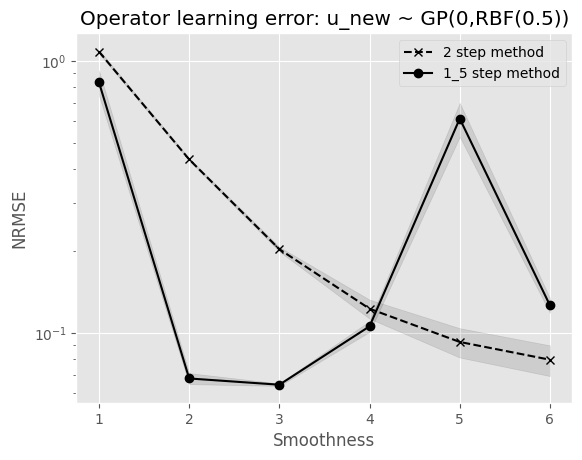

In [5]:
NUM_RUNS = 3
REGULARITY = [1,2,3,4,5,6]
# Operator learning errors plot
plt.title('Operator learning error: u_new ~ GP(0,RBF(0.5))')
alphas = REGULARITY
# Colors
c2 = 'black'
c1 = 'black'
# 2-step method plot
mean_i_opt_2 = jnp.array([jnp.mean(e) for e in jnp.array(err['2_mthd'])])
sd_i_opt_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'])])
# Plot 2 method
plt.plot(alphas, mean_i_opt_2, label = f'2 step method', marker= 'x', color = c2,linestyle = 'dashed')
plt.fill_between(alphas, mean_i_opt_2 - sd_i_opt_2, mean_i_opt_2 + sd_i_opt_2, alpha=.1, color = c2)
plt.yscale('log')
# 1_5 step method plot

# 1_5 method
mean_i_opt_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'])])
sd_i_opt_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'])])
# Plot 1_5 method
plt.plot(alphas, mean_i_opt_1_5, label =  f'1_5 step method', marker= 'o', color = c1)
plt.fill_between(alphas, mean_i_opt_1_5 - sd_i_opt_1_5, mean_i_opt_1_5 + sd_i_opt_1_5, alpha=.1, color = c1)
plt.yscale('log')

plt.legend()

plt.ylabel('NRMSE')
plt.xlabel('Smoothness')
# # adding labels to the plotlines
# xvals_2step = [5]*4 + [7.5]
# xvals_1step = [6.5]+[7]*4
# xvals = xvals_2step + xvals_1step
# lines = plt.gca().get_lines()
# labelLines(lines, align=True, xvals = xvals)
# # add legend box
# legend_elements = [Line2D([0], [0], color= c2, label='2-step'),
#                    Line2D([0], [0], color= c1, label='1.5-step')]
# plt.legend(handles = legend_elements, loc = 'upper right')
plt.show()

## Error vs. observed points

In [6]:
err = {
    '1_5_mthd': [],
    '2_mthd':   []
}

In [ ]:
NUM_RUNS = 3
N = [10,20,30,40,50,60]

In [ ]:
for n in N:
    i_opt_1_5 = []
    i_opt_2 = []
    for run in range(NUM_RUNS):
        # Run
        res = run_exp_opt_err(2,n,run)
        # Append
        i_opt_1_5.append(res[0])
        i_opt_2.append(res[1])
    # Append each list    
    err['1_5_mthd'].append(i_opt_1_5)
    err['2_mthd'].append(i_opt_2)   
# Save after
jnp.save('errors_opt/err_vs_N', err)

In [11]:
err = jnp.load('errors_opt/err_vs_N.npy', allow_pickle=True).item()

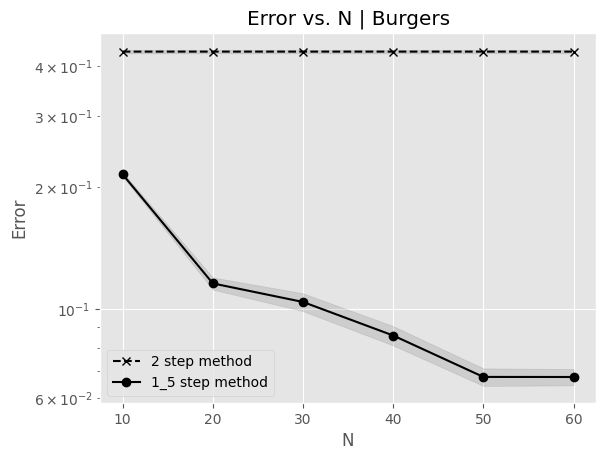

In [12]:
# Collocation points errors plot
plt.title('Error vs. N | Burgers')
# Colors
c2 = 'black'
c1 = 'black'
# 2-step method plot
mean_i_opt_2 = jnp.array([jnp.mean(e) for e in jnp.array(err['2_mthd'])])
sd_i_opt_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'])])
# Plot 2 method
plt.plot(N, mean_i_opt_2, label = f'2 step method', marker= 'x', color = c2,linestyle = 'dashed')
plt.fill_between(N, mean_i_opt_2 - sd_i_opt_2, mean_i_opt_2 + sd_i_opt_2, alpha=.1, color = c2)
plt.yscale('log')
# 1_5 step method plot

# 1_5 method
mean_i_opt_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'])])
sd_i_opt_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'])])
# Plot 1_5 method
plt.plot(N, mean_i_opt_1_5, label =  f'1_5 step method', marker= 'o', color = c1)
plt.fill_between(N, mean_i_opt_1_5 - sd_i_opt_1_5, mean_i_opt_1_5 + sd_i_opt_1_5, alpha=.1, color = c1)
plt.yscale('log')

plt.legend()

plt.ylabel('Error')
plt.xlabel('N')
# # adding labels to the plotlines
# xvals_2step = [5]*4 + [7.5]
# xvals_1step = [6.5]+[7]*4
# xvals = xvals_2step + xvals_1step
# lines = plt.gca().get_lines()
# labelLines(lines, align=True, xvals = xvals)
# # add legend box
# legend_elements = [Line2D([0], [0], color= c2, label='2-step'),
#                    Line2D([0], [0], color= c1, label='1.5-step')]
# plt.legend(handles = legend_elements, loc = 'upper right')
plt.show()